#Predicting Insurance Costs

For this project, we'll be looking at the Medical Cost Data Set from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it. For our regression problem, we're interested in how these different characteristics relate to the total medical cost

we want to construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

##Stage 1. Load the data and explore 

In [3]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [4]:
insurance = pd.read_csv('insurance.csv')

variables that are highly correlated with the outcome are better candidates for use in a predictive linear regression model

In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset has 7 columns. 3 categorical variables

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

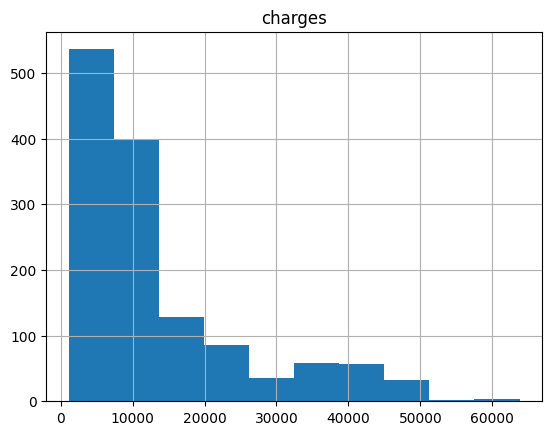

In [11]:
insurance.hist("charges")

The charges column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

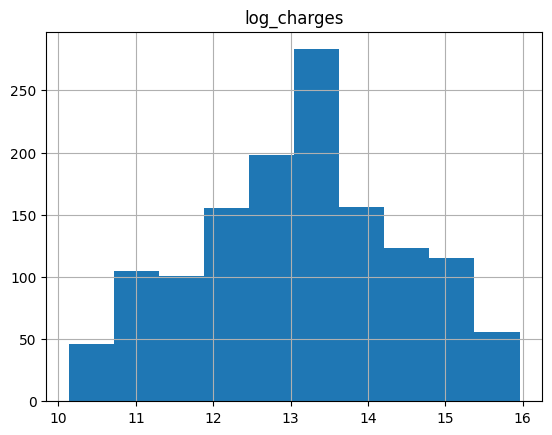

In [12]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")
     

The log-transformed charges values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

In [13]:
#Lets check for correlation
correlations = insurance.corr()

In [15]:
print(correlations)

                  age       bmi  children   charges  log_charges
age          1.000000  0.109272  0.042469  0.299008     0.527834
bmi          0.109272  1.000000  0.012759  0.198341     0.132669
children     0.042469  0.012759  1.000000  0.067998     0.161336
charges      0.299008  0.198341  0.067998  1.000000     0.892964
log_charges  0.527834  0.132669  0.161336  0.892964     1.000000


Comments on correlation
age has 30% correlation with charges, bmi has 19.8% correlation, and number of children has 6.7% correlation

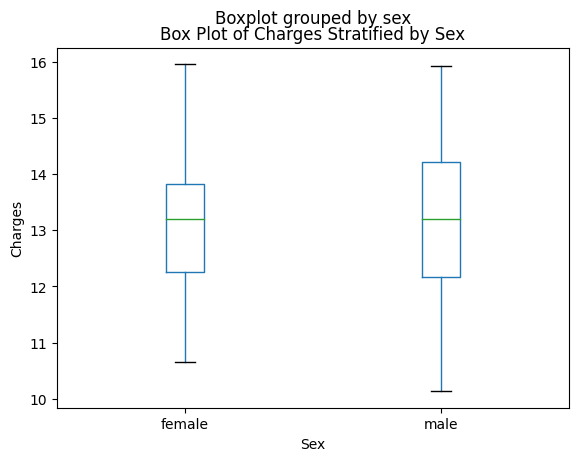

In [19]:
import matplotlib.pyplot as plt

insurance.boxplot(column='log_charges', by='sex', grid=False)
plt.title('Box Plot of Charges Stratified by Sex')
plt.ylabel('Charges')
plt.xlabel('Sex')
plt.show()



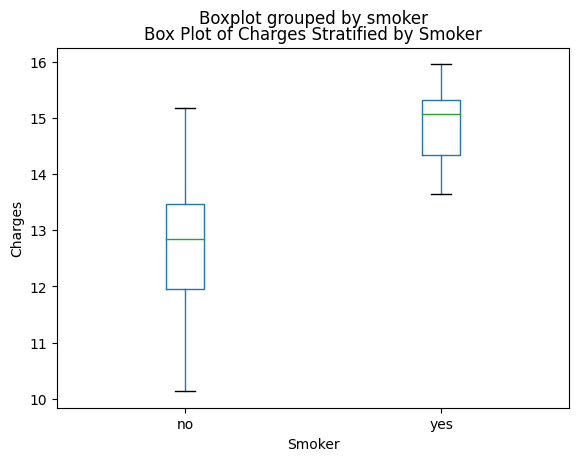

In [20]:

insurance.boxplot(column='log_charges', by='smoker', grid=False)
plt.title('Box Plot of Charges Stratified by Smoker')
plt.ylabel('Charges')
plt.xlabel('Smoker')
plt.show()

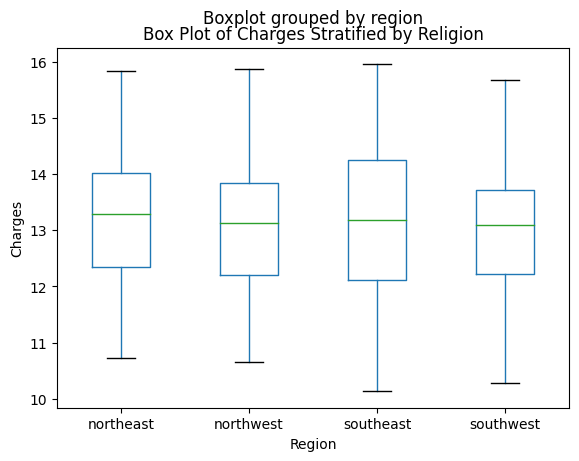

In [21]:

insurance.boxplot(column='log_charges', by='region', grid=False)
plt.title('Box Plot of Charges Stratified by Religion')
plt.ylabel('Charges')
plt.xlabel('Region')
plt.show()

Comments on plots
Males seem to have a wider distribution of charges compared to women. Smokers have much higher costs than non-smokers. There doesn't seem tobe many appreciable differences between regions.

Based on the univariate relationships shown above, age, bmi and smoker are positively associated with higher charges. We'll include these predictors in our final model.

##Stage 2 Divide The Data

Before we can build the model, we need to divide the insurance dataset into two portions:

1. A training set that will be used to estimate the regression coefficients
2. A test set that will be used to assess the predictive ability of the model

In [22]:

# Splitting the data up into a training and test set
insurance["is_smoker"] = (insurance["smoker"] == "yes")
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 1)

##Stage 4 · Build The Model

Now that we've divided up the data into both a training and test set, we're ready to build our predictive linear model. After we build the model, take the time to examine the regression coefficients and the coefficient of determination. We can ask ourselves a few things:

1. Do the coefficient values make sense considering their correlation with the outcome?
2. What does the coefficient of determination suggest about the model fit?
3. How well does the model predict the medical costs in the training set?

In [23]:
# Training and checking model performance on training set
model = LinearRegression()
model.fit(X_train, y_train)
     

LinearRegression()

In [24]:
# Get predicted values by model
y_pred = model.predict(X_train)

# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)

0.45188410556701514

In [25]:

# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.5712698365981919

In [26]:
# Coefficient of determination
r2_score(y_train, y_pred)
     

0.7401147505859649

Observations
The training MSE for the model is 0.454 and is 1.57 on the original scale. The 
 indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

##Stage · Residual Diagnostics

We now have a working predictive model for medical costs! Before we examine it more closely, we should check how well the assumptions of linear regression are met.

<AxesSubplot:xlabel='fitted', ylabel='residuals'>

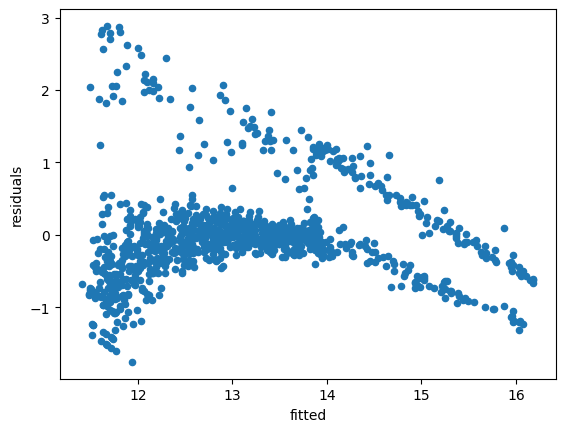

In [27]:
# Quick visual check of residuals
check = pd.DataFrame()
check["residuals"] = y_train - y_pred
check["fitted"] = y_pred

check.plot.scatter(x = "fitted", y = "residuals")

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

##Stage 6 · Interpreting The Model

In [29]:
# Getting the non-intercept coefficients
model.coef_

array([0.04983948, 0.01422752, 2.21807367])

##Stage 7 · Final Model Evaluation

It's time to see how the model performs on the test data, which represents a set of new observations that it hasn't been trained on. Predictions should be accurate on any new observations if we want to use it in the new world.

In [31]:
# Getting MSE on test model
test_pred = model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.43968114625714

In [32]:
# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_pred))

1.5522122109248526


##Stage 8· Drawing Conclusions

The test MSE was about 0.435, while the training MSE was about 0.454. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.